# NLP Explore Notebook

In [51]:
import re
import unicodedata
import pandas as pd
import nltk
from wordcloud import WordCloud, ImageColorGenerator, get_single_color_func
import random

import matplotlib.pyplot as plt
import seaborn as sns

import acquire as aq
import prepare as prep
from env import user, password, host

### 1. Spam Data

#### Load the spam data set.


In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Cleaning...

In [3]:
def basic_clean(dirty_words):
    '''This function takes in words (single word, article, paragraph, etc) and then 
    lowercases all letters, normalizes the letters, and removes special characters'''
        # Lowercases all letters
    all_lower_case_words = dirty_words.lower()
        # Normalizes the letters
    normalized_words = unicodedata.normalize('NFKD', all_lower_case_words).encode('ascii', 'ignore').decode('utf-8')
        # Removes special chars
    remove_special_characters = re.sub(r"[^a-z0-9'\s]", '', normalized_words)
    return remove_special_characters

In [4]:
# combine all messages in single string by label

ham_words = basic_clean(' '.join(df[df.label == 'ham'].text))
spam_words = basic_clean(' '.join(df[df.label == 'spam'].text))
all_words = basic_clean(' '.join(df.text))

In [5]:

ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [6]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['ham', 'spam', 'all']
word_counts.head()

,ham,spam,all
i,2305,45,2350
you,1837,287,2124
to,1554,686,2240
the,1118,204,1322
a,1055,376,1431


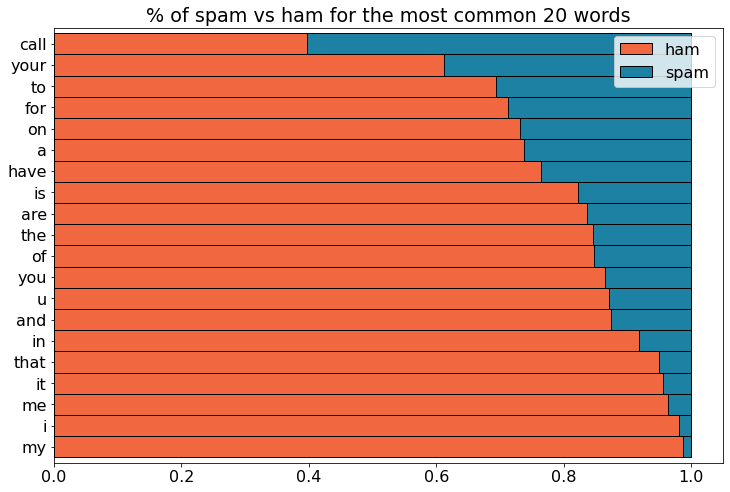

In [7]:

plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'spam')
 .plot.barh(stacked = True, width = 1, ec = 'k', color=['#F06740', '#1C81A3'], figsize=(12, 8)))


plt.title('% of spam vs ham for the most common 20 words')

plt.show()

#### Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [8]:
ham_bigram = pd.DataFrame(nltk.bigrams(ham_words.split()))
ham_bigram.value_counts().head()

0     1   
are   you     173
i     am      132
have  a       110
i     will     98
you   are      91
dtype: int64

In [9]:
spam_bigram = pd.DataFrame(nltk.bigrams(spam_words.split()))
spam_bigram.value_counts().head()

0       1     
you     have      73
have    won       54
your    mobile    49
to      claim     46
please  call      44
dtype: int64

In [10]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(200, 50%%, %d%%)" % random.randint(60, 100)

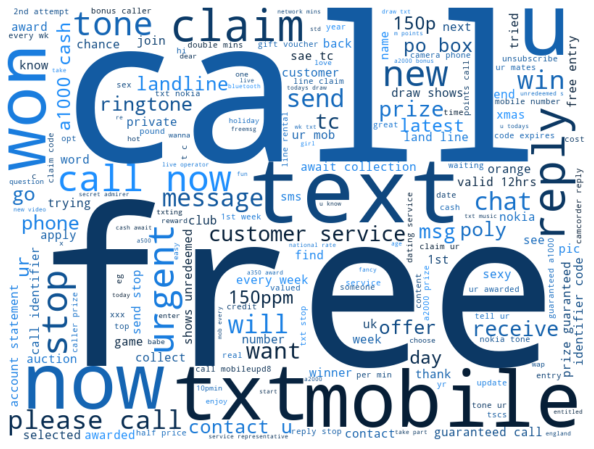

In [11]:
color_func1 = get_single_color_func('dodgerblue')


plt.figure(figsize=(12, 8))
img = WordCloud(background_color='white', width=800, height=600).generate(spam_words)
plt.imshow(img.recolor(color_func=color_func1, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

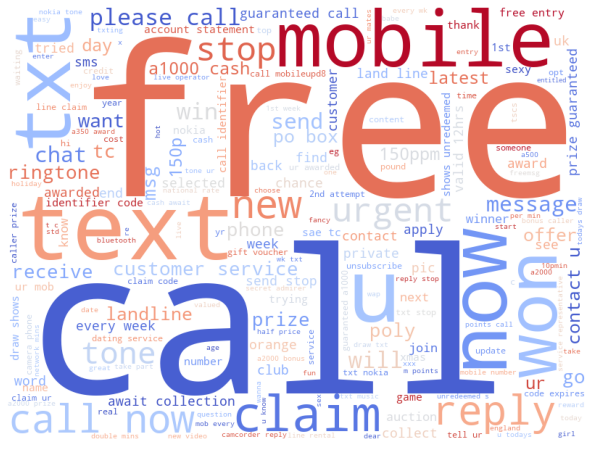

In [12]:
plt.figure(figsize=(12, 8))
img = WordCloud(background_color='white', width=800, height=600).generate(spam_words)
plt.imshow(img.recolor(colormap='coolwarm'))
plt.axis('off')
plt.show()

#### Is there any overlap in the bigrams for the spam data and the ham data?

- No, there is not

In [13]:
ham_bigram = ham_bigram.rename(columns={0:'first_word', 1:'second_word'})
ham_bigram['ham_combined'] = ham_bigram.first_word + ' ' + ham_bigram.second_word

In [14]:
ham_bigram = ham_bigram.drop(columns=['first_word', 'second_word'])
ham_bigram.head()

,ham_combined
0,go until
1,until jurong
2,jurong point
3,point crazy
4,crazy available


In [15]:
spam_bigram = spam_bigram.rename(columns={0:'first_word', 1:'second_word'})
spam_bigram['spam_combined'] = spam_bigram.first_word + ' ' + spam_bigram.second_word

In [16]:
spam_bigram = spam_bigram.drop(columns=['first_word', 'second_word'])
spam_bigram.head()

,spam_combined
0,free entry
1,entry in
2,in 2
3,2 a
4,a wkly


In [17]:
spam_bigram.size

17593

In [18]:
ham_bigram.size

67535

In [32]:
#pd.merge(ham_bigram, spam_bigram, how='left', left_index=True)
bigrams_combined = ham_bigram.merge(spam_bigram, how='left', left_index=True, right_index=True)
bigrams_combined.head()

,ham_combined,spam_combined
0,go until,free entry
1,until jurong,entry in
2,jurong point,in 2
3,point crazy,2 a
4,crazy available,a wkly


In [34]:
bigrams_combined[bigrams_combined.ham_combined == bigrams_combined.spam_combined]

,ham_combined,spam_combined


#### Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [35]:
ham_bigram = pd.DataFrame(nltk.trigrams(ham_words.split()))
ham_bigram.value_counts().head()

0      1     2    
i'll   call  later    39
sorry  i'll  call     38
how    are   you      35
i      want  to       29
let    me    know     26
dtype: int64

In [36]:
spam_bigram = pd.DataFrame(nltk.trigrams(spam_words.split()))
spam_bigram.value_counts().head()

0       1           2     
you     have        won       37
have    won         a         33
prize   guaranteed  call      21
a1000   cash        or        19
urgent  your        mobile    18
dtype: int64

### 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [39]:
blog = aq.get_blog_articles()
blog.head()

,title,published,content
0,Boris – Behind the Billboards,"Oct 3, 2021",
1,Is Codeup the Best Bootcamp in San Antonio…or ...,"Sep 16, 2021",Looking for the best data science bootcamp in ...
2,Codeup Launches First Podcast: Hire Tech,"Aug 25, 2021",Any podcast enthusiasts out there? We are plea...
3,Why Should I Become a System Administrator?,"Aug 23, 2021","With so many tech careers in demand, why choos..."
4,Announcing our Candidacy for Accreditation!,"Jun 30, 2021",Did you know that even though we’re an indepen...


In [48]:
blog_content = blog.content.str.cat(sep=" ")

In [52]:
blog_content = prep.prep_a_writting(blog_content)

In [53]:
blog_bigram = pd.DataFrame(nltk.bigrams(blog_content.split()))
blog_bigram.value_counts().head()

0      1        
data   science      22
san    antonio      20
data   scientist    13
vet    tec          13
cloud  academy      11
dtype: int64

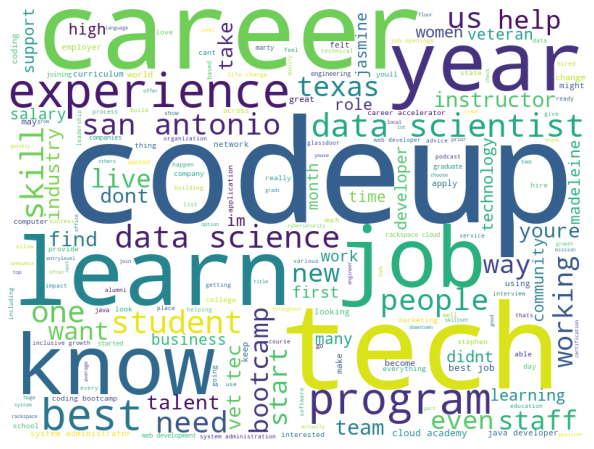

In [56]:
plt.figure(figsize=(12, 8))
img = WordCloud(background_color='white', width=800, height=600).generate(blog_content)
plt.imshow(img.recolor(colormap='viridis'))
plt.axis('off')
plt.show()

### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [58]:
news = aq.get_inshorts_articles()
news.head()

,title,published,author,content,category
0,"Reliance Jio declines AGR dues moratorium, bec...",2021-10-30T07:20:30.000Z,Kiran Khatri,Reliance Jio has reportedly said it won't opt ...,business
1,"If you die in metaverse, you die in real life:...",2021-10-30T07:16:16.000Z,Kiran Khatri,After Facebook changed the company's name to M...,business
2,Elon Musk becomes world's 1st person to cross ...,2021-10-30T09:21:54.000Z,Kiran Khatri,Tesla CEO Elon Musk has become the world's fir...,business
3,Microsoft overtakes Apple as world's most valu...,2021-10-29T15:22:45.000Z,Arshiya Chopra,Microsoft Corp on Friday overtook Apple Inc to...,business
4,"'Squid Game' crypto surges 1,00,000% in days, ...",2021-10-30T06:13:05.000Z,Kiran Khatri,"A cryptocurrency called 'Squid Game', inspired...",business


In [59]:
news_content = news.content.str.cat(sep=" ")

In [60]:
news_content = prep.prep_a_writting(news_content)

In [61]:
news_bigram = pd.DataFrame(nltk.bigrams(news_content.split()))
news_bigram.value_counts().head()

0         1      
world     cup        20
t20       world      19
tesla     ceo         8
facebook  changed     8
ceo       elon        8
dtype: int64

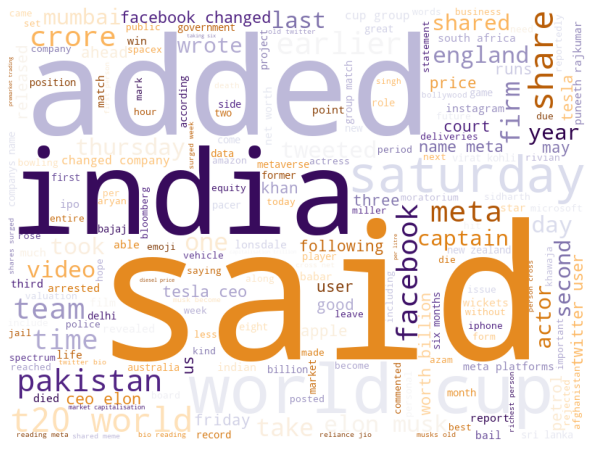

In [64]:
plt.figure(figsize=(12, 8))
img = WordCloud(background_color='white', width=800, height=600).generate(news_content)
plt.imshow(img.recolor(colormap='PuOr'))
plt.axis('off')
plt.show()